
# **Appendix**



<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 3

### Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br> 

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br> 


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

## Import packages 

In [2]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Create a Helper Function to Plot Graphs:

In [4]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Verify TensorFlow Version and Keras Version

In [5]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.4.1


In [6]:
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Mount Google Drive to Colab Environment

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###  TensorFlow Datasets Information<br>
<div class="alert alert-block alert-info">
    <b> ag_news_subset</b><br>
    See https://www.tensorflow.org/datasets/catalog/ag_news_subset
    </div>

Get all the words in the documents (as well as the number of words in each document) by using the encoder to get the indices associated with each token and then translating the indices to tokens. But first we need to get the "unpadded" new articles so that we can get their length.

In [9]:
#register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

2021-02-20 19:51:31.137476: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
I0220 19:51:34.107089 140320970397568 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
2021-02-20 19:51:34.123344: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-02-20 19:51:34.197100: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-02-20 19:51:34.259667: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
I0220 19:51:34.321993 140320970397568 dataset_info.py:434] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GC

###  Exploratory Analysis AG News Subset

**Get information about the ag_news_subset dataset. We combined the training and test data for a total of 127,600 news articles.**

In [10]:
info

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [11]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


### Review Labels (Categories) 

In [12]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


In [13]:
# classes dictionary
categories =dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

The 127,600 news articles are evenly distributed among the 4 categories

In [14]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

We will use the tf.keras.layers.experimental.preprocessing.TextVectorization layer to transform each news article into a "list" of non-negative integers representing the tokens in the news article.

For the purpose of training our models each such "encoding" will have a fixed length corresponding to the news article(s) with the most tokens. Shorter articles will be right-padded with zeros in the encoding. Also to speed up the training process, we will set max_tokens = 1000 so that words not in the vabulary set of top 1000 most common tokes are encoded as 1. But first we set max_tokens = None (which is the default value) in order to get the vocabulary size of the corpus.


In [15]:
%%time
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None)
encoder.adapt(dataset_all.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())



Cause: could not parse the source code of <function <lambda> at 0x7f01901cdae8>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f01901cdae8>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f01901cdae8>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 2min 4s, sys: 26.8 s, total: 2min 31s
Wall time: 1min 34s


In [16]:
print(f"There are {len(vocab)} vocabulary words in the corpus.")

There are 95976 vocabulary words in the corpus.


There are 95976 vocabulary words in the corpus.

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [17]:
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U150')

Let's use how the encoding works on a sample string all of whose words are in the vocabulary of the corpus

In [18]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is in the vocabulary.
"ran" is in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


In [19]:
encoder(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([   2, 5958, 1287,   29,    3,  232, 1414,   14,   19, 2548,   18,
          2, 2435,    8,    2,  999])>

Let us get the total number of words in the corpus and the sizes of the news articles

In [20]:
%%time
doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = encoder(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

CPU times: user 13min 49s, sys: 1min 32s, total: 15min 21s
Wall time: 12min 55s


In [21]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 3909695 words in the corpus of 127600 news articles.
Each news article has between 3 and 173 tokens in it.


Text(0, 0.5, 'Number of AG News Articles')

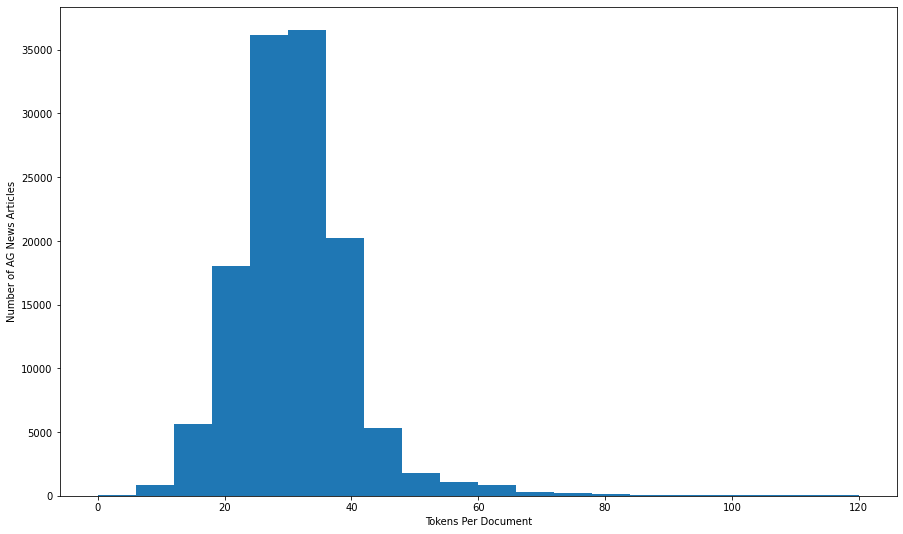

In [22]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles")

Encode the news articles using the top 1000 most common words in the corpus

In [23]:
%%time
encoder_1000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000)
encoder_1000.adapt(dataset_all.map(lambda text, label: text))
vocab_1000 = np.array(encoder_1000.get_vocabulary())

Cause: could not parse the source code of <function <lambda> at 0x7f01278e1bf8>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f01278e1bf8>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f01278e1bf8>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 2min 4s, sys: 26 s, total: 2min 30s
Wall time: 1min 33s


The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [24]:
vocab_1000[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

In particular, 0 is use for padding, 1 for the unknown words, 2 for the common word, i.e. 'the', etc. Let us look at the same example we encoded previously using the encoder for all the vocabulary words. Note that there are now five 1's denoting words that are not in the top 1000 in frequency.

We encode the same example as before using the new encoder. Note that there are now 5 out of vocabulary words.

In [25]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
encoder_1000(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([  2,   1,   1,  29,   3, 232,   1,  14,  19,   1,  18,   2,   1,
         8,   2, 999])>

In [26]:
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab_1000  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is *not* in the vocabulary.
"ran" is *not* in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is *not* in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is *not* in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is *not* in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


We want to determine the number of non-vocabulary words in each news articles (denoted by 1s in the encoding)

In [27]:
%%time
doc1000_sizes = []
corpus1000 = []
count1000=0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_1000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 16min 15s, sys: 1min 41s, total: 17min 57s
Wall time: 15min 19s


In [28]:
print(f"There are {len(corpus1000)} words in the corpus of {len(doc1000_sizes)} news articles.")
print(f"Each news article has between {min(doc1000_sizes)} and {max(doc1000_sizes)} tokens in it.")

There are 3909695 words in the corpus of 127600 news articles.
Each news article has between 3 and 173 tokens in it.




Note below that most of the news articles consists of at least 60% (top 1000) vocabulary words (with only 22 out for 127,600 news articles containing no top 1000 vacabulary words)

In [29]:
Counter(percents).most_common(10)
np.unique(percents, return_counts=True) 

(array([  0,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  95,  97, 100]),
 array([  12,    5,   20,   29,   49,   71,  120,  137,  172,  274,  486,
         368,  682,  777,  828, 1346, 1376, 2123, 1610, 2863, 2687, 3018,
        3957, 3315, 4605, 3934, 4148, 5737, 4954, 5072, 6123, 6165, 3255,
        5095, 4596, 3438, 5880, 4205, 3109, 4063, 3555, 3030, 2904, 2294,
        1967, 1716, 2174,  368, 2486,  234, 1246,  747,  573,  547,  520,
         441,  348,  217,  250,  135,  234,   49,  131,  101,   11,  135,
          40,  

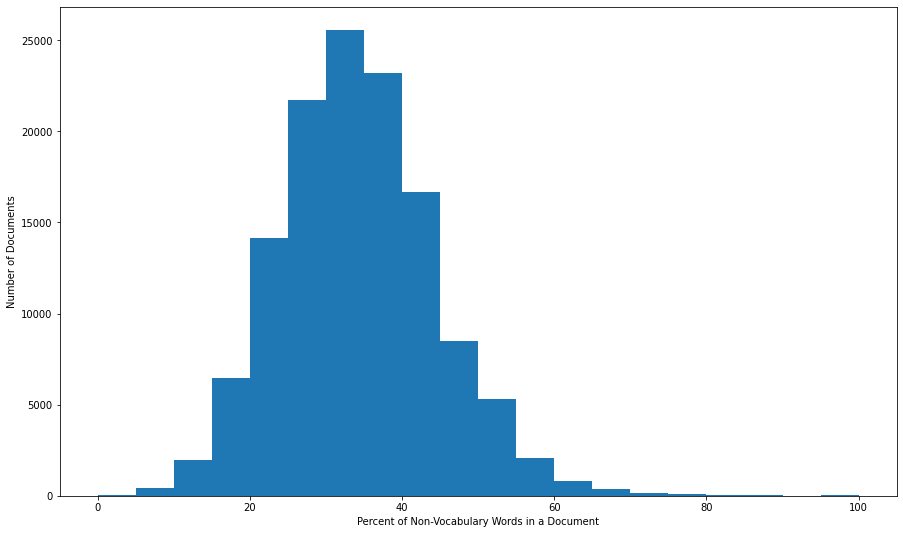

In [30]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [31]:
print(f"There are {len(corpus1000)} words in the corpus with {useless} documents not containing any of the top {len(vocab_1000)} vocabulary words.")
print(f"There are {count1000} top {len(vocab_1000)} vocabulary words in the corpus.")

There are 3909695 words in the corpus with 22 documents not containing any of the top 1000 vocabulary words.
There are 2602670 top 1000 vocabulary words in the corpus.


### Preprocessing Data Create Input Pipeline

In [32]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2021-02-20 20:24:13.174102: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
I0220 20:24:16.083602 140367600310144 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0220 20:24:16.084728 140367600310144 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0220 20:24:16.086317 140367600310144 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0220 20:24:16.086621 140367600310144 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.\nComeToMyHead is an academic news search engine which has been running since July, 2004.\nThe dataset is provided by the 

In [33]:
####  Dataset Splits (Training, Test, Validation)
#### .8934 Training, .0470 Test, .0596 Validation

In [34]:
len(train_dataset),len(validation_dataset),len(test_dataset) 
# len(train_dataset),len(test_dataset) 

(114000, 6000, 7600)

### Review Distribution of Categorical Labels for the 114000 training data (news articles)

In [35]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

Review Example with Interger Label Encoded Classification(text, label pairs):

In [36]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [37]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [38]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [39]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Nearly a decade in the making, the MBTA is entering the homestretch of a new \\$140 million fare collection system as officials yesterday unveiled the CharlieCard, #39; #39; a debit-type card to be used on the T in 2006.'
 b'THE GRAND NABOB of the world #39;s software giant, Microsoft, Bill Gates, has told technologists that he is not afraid of Linux. Speaking at a shindig at the Computer History Museum, Gates said that he had seen '
 b'The volume of worms and viruses is increasing, but the rate of successful attacks has dropped, according to a new report from Symantec.']

labels:  [3 3 3]
texts:  [b'Kraft, the largest US food company, on Monday will reveal details of a high-stakes marketing gamble to tie many of its lines with the popular South Beach diet.'
 b'PalmSource is to focus on wireless devices with its new version of Palm OS, but can it succeed against the likes of Microsoft and Symbian?'
 b"AP - The Baltimore Ravens did their part to get into the playoffs. It wasn

In [40]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b'By TARA BURGHART     CHICAGO (AP) -- When Rueben Martinez became a barber in the Los Angeles area, his love of literature inspired him to lend out books for customers. He noticed that few books made their way back to him...'
 b'LA CROSSE, Wis. - In 2000, political pundits summed up the race in three words: Florida, Florida, Florida...'
 b'Ford Motor Co. said Monday it will begin offering Sirius Satellite Radio as a dealer-installed option in four more vehicles by year #39;s end and is targeting up to 20 vehicle ']

labels:  ['Sci/Tech', 'World', 'Business']

texts:  [b'The previous NL game in an AL ballpark was in 1946, when the Boston Braves played several games at Fenway Park because a paint job on the seats at Braves Field had not dried, according to the Elias Sports Bureau.'
 b'South Korea #39;s economy may miss its 5 percent growth target for 2004 after expanding at its slowest pace in a year in the third quarter, the finance minister said.'
 b' SINGAPORE (Reuters) - Oi

## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [41]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [42]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

1000

In [43]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

Here are the 20 least frequent words.

In [44]:
vocab[-20:]

array(['black', 'turn', 'build', 'countrys', 'advanced', 'whose',
       'crisis', 'create', '23', 'sources', 'body', 'militant', 'hope',
       'event', 'started', 'ready', 'jones', 'lawsuit', 'focus',
       'singapore'], dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [45]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2,   1,   1,  87,   6,  22, 783,   1,  27,   6,   1,  68,   2,
        288,   1,   1, 385, 203,  15,   1, 872, 220,   3,   1, 545,   8,
          2,   1,  15,   1, 487,  67,  60,   1, 146,   4,   2,   1, 210,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [197, 626,  11, 353, 107,   1,  13, 705,  88, 272, 966,   9, 112,
         29,   1,  15,  13,   1,   1,   6,   3,  63,   6,   2, 155, 221,
          2, 968,  97,  17,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [999,  28,  70,  94, 240,   9,   2, 103, 121,   6,   3,   1,   8,
         45,  12,  22,   1,   1, 814,   4, 247,   2,  72, 114,  95,  76,
          1,  47, 443,   9,   1,   1,   0,   0,   0,   0,   0,   0,   0,
          0, 

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [46]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'The previous NL game in an AL ballpark was in 1946, when the Boston Braves played several games at Fenway Park because a paint job on the seats at Braves Field had not dried, according to the Elias Sports Bureau.'
Round-trip:  the [UNK] [UNK] game in an al [UNK] was in [UNK] when the boston [UNK] [UNK] several games at [UNK] park because a [UNK] job on the [UNK] at [UNK] field had not [UNK] according to the [UNK] sports [UNK]                           

Original:  b'South Korea #39;s economy may miss its 5 percent growth target for 2004 after expanding at its slowest pace in a year in the third quarter, the finance minister said.'
Round-trip:  south korea 39s economy may [UNK] its 5 percent growth target for 2004 after [UNK] at its [UNK] [UNK] in a year in the third quarter the finance minister said                                     

Original:  b' SINGAPORE (Reuters) - Oil prices rose for the second day in  a row on Thursday with an Arctic blast forecast to hit the  Uni

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

# Experiment 1

In [47]:
num_classes = 4
model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=32
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(32, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [49]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


## Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [50]:
%%time
history = model.fit(train_dataset
                    ,epochs = 5
                    ,validation_data=validation_dataset
                    )

Epoch 1/5
1782/1782 [==============================] - 47s 18ms/step - loss: 1.1274 - accuracy: 0.4919 - val_loss: 0.5423 - val_accuracy: 0.8158
Epoch 2/5
1782/1782 [==============================] - 30s 17ms/step - loss: 0.5165 - accuracy: 0.8213 - val_loss: 0.4686 - val_accuracy: 0.8367
Epoch 3/5
1782/1782 [==============================] - 29s 16ms/step - loss: 0.4588 - accuracy: 0.8366 - val_loss: 0.4484 - val_accuracy: 0.8407
Epoch 4/5
 678/1782 [==========>...................] - ETA: 17s - loss: 0.4405 - accuracy: 0.8457

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

## Plotting Performance Metrics - Single Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10)

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, "BiDirectionalLSTM.png", show_shapes=True)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

# Experiment 2

In [ ]:
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 32, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(32, activation='relu')
                              ,tf.keras.layers.Dense(32, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history2 = model2.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

In [ ]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail()

In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

#### Model Architecture Summary Single Layer Bidirectional RNN

In [ ]:
model2.summary()

In [ ]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).


# Experiment 3

In [ ]:
model3 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model3.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history3 = model3.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model3.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 4

In [ ]:
model4 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model4.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history4 = model4.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model4.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 5

In [ ]:
model5 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))
                              ,tf.keras.layers.Dense(128, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model5.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history5 = model5.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model5.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 6

In [ ]:
model6 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))
                              ,tf.keras.layers.Dense(128, activation='relu')
                              ,tf.keras.layers.Dense(128, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model6.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history6 = model6.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model6.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 7

In [ ]:
model7 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 256, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256))
                              ,tf.keras.layers.Dense(256, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model7.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history7 = model7.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model7.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 8

In [ ]:
model8 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 256, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256))
                              ,tf.keras.layers.Dense(256, activation='relu')
                              ,tf.keras.layers.Dense(256, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model8.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history8 = model8.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model8.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 9

In [ ]:
model9 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 512, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model9.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history9 = model9.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model9.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 10

In [ ]:
model10 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 512, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model10.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history10 = model10.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model10.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 11

In [ ]:
model11 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 256, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model11.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history11 = model11.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model11.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 12

In [ ]:
model12 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 1024, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model12.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history12 = model12.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model12.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model12.predict(test_dataset)
predicted_categories = tf.argmax(y_pred, axis=1)


true_categories = tf.concat([y for x, y in test_dataset], axis=0)

confusion_matrix(predicted_categories, true_categories)

In [ ]:
from sklearn.metrics import precision_score
precision_score(true_categories, predicted_categories, average='micro')

In [ ]:
from sklearn.metrics import recall_score
recall_score(true_categories, predicted_categories, average='micro')

# Experiment 13

In [ ]:
model13 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 1024, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model13.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history13 = model13.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model13.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 14

In [ ]:
model14 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 1024, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model14.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history14 = model14.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model14.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 15

In [ ]:
from tensorflow.keras import regularizers
model15 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 1024, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax', kernel_regularizer='l1')   # not binary since there are num_classes categories
])

In [ ]:
model15.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history15 = model15.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model15.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 16

In [ ]:
model16 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 1024, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax', kernel_regularizer='l2')   # not binary since there are num_classes categories
])

In [ ]:
model16.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history16 = model16.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model16.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 17

In [ ]:
model17 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 1024, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model17.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history17 = model17.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

In [ ]:
test_loss, test_acc = model17.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 18

In [ ]:

encoder_none = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=None)
encoder_none.adapt(train_dataset.map(lambda text, label: text))
model18 = tf.keras.Sequential([
                              encoder_none
                              ,tf.keras.layers.Embedding(len(encoder_none.get_vocabulary()), 1024, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])



In [ ]:
model18.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history18 = model18.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model18.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 19

In [ ]:
encoder_500 = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=500)
encoder_500.adapt(train_dataset.map(lambda text, label: text))
model19 = tf.keras.Sequential([
                              encoder_500
                              ,tf.keras.layers.Embedding(len(encoder_500.get_vocabulary()), 1024, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])


In [ ]:
model19.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history19 = model19.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model19.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 20

In [ ]:
encoder_none = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=200)
encoder_none.adapt(train_dataset.map(lambda text, label: text))
model20 = tf.keras.Sequential([
                              encoder_none
                              ,tf.keras.layers.Embedding(len(encoder_none.get_vocabulary()), 1024, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])


In [ ]:
model20.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history20 = model20.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model20.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 21

In [ ]:
encoder_none = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=1000, output_sequence_length=10)
encoder_none.adapt(train_dataset.map(lambda text, label: text))
model21 = tf.keras.Sequential([
                              encoder_none
                              ,tf.keras.layers.Embedding(len(encoder_none.get_vocabulary()), 1024, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model21.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history21 = model21.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model21.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Experiment 22

In [54]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import GlobalMaxPooling1D
from keras.layers import Dense, Activation, Flatten

model22 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero=True)
                              ,tf.keras.layers.Conv1D(32,7)
                              ,tf.keras.layers.MaxPooling1D(5)
                              ,tf.keras.layers.GlobalMaxPooling1D()
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')]) 

In [55]:
model22.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()  # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [56]:
%%time
history22 = model22.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

Epoch 1/5
1782/1782 [==============================] - 16s 8ms/step - loss: 0.7222 - accuracy: 0.7272 - val_loss: 0.4113 - val_accuracy: 0.8500
Epoch 2/5
1782/1782 [==============================] - 11s 6ms/step - loss: 0.3924 - accuracy: 0.8590 - val_loss: 0.3905 - val_accuracy: 0.8651
Epoch 3/5
1782/1782 [==============================] - 11s 6ms/step - loss: 0.3591 - accuracy: 0.8703 - val_loss: 0.3569 - val_accuracy: 0.8734
Epoch 4/5
1782/1782 [==============================] - 11s 6ms/step - loss: 0.3313 - accuracy: 0.8799 - val_loss: 0.3915 - val_accuracy: 0.8615
Epoch 5/5
1782/1782 [==============================] - 11s 6ms/step - loss: 0.3063 - accuracy: 0.8896 - val_loss: 0.3502 - val_accuracy: 0.8755
CPU times: user 1min 38s, sys: 24.6 s, total: 2min 2s
Wall time: 58.6 s


In [57]:
test_loss, test_acc = model22.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 5ms/step - loss: 0.4110 - accuracy: 0.8532
Test Loss: 0.41099876165390015
Test Accuracy: 0.8531578779220581


# Experiment 23

In [ ]:
model23 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 1024, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(512,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(512, return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(512))
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(512, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model23.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
%%time
history23 = model23.fit(train_dataset
                    ,epochs=5
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    )

In [ ]:
test_loss, test_acc = model23.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))